In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

warnings.filterwarnings('ignore')
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dot Product with RMSE loss function

In [12]:
from helpers import load_data

DATA_TRAIN_PATH = "data/data_train.csv"
ratings = load_data(DATA_TRAIN_PATH)

DATA_TEST_PATH = "data/sampleSubmission.csv"
samples = load_data(DATA_TEST_PATH)

In [14]:
n_users = len(ratings.user_id.unique())
n_movies = len(ratings.movie_id.unique())

In [15]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size=0.1, random_state=42)

In [16]:
test.head()

,user_id,movie_id,rating
904556,5062,706,2
171326,9044,148,4
190893,1736,169,4
1082109,5270,877,1
881877,6100,691,4


In [17]:
#creating movie embedding path
movie_input = Input(shape=[1], name="Movie-Input")
movie_embedding = Embedding(n_movies+1, 5, name="Movie-Embedding")(movie_input)
movie_vec = Flatten(name="Flatten-Movies")(movie_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# performing dot product and creating model
prod = Dot(name="Dot-Product", axes=1)([movie_vec, user_vec])
model = Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

Epoch 1/20
1059256/1059256 [==============================] - 47s 45us/step - loss: 1.0136
Epoch 2/20
1059256/1059256 [==============================] - 43s 41us/step - loss: 1.0077
Epoch 3/20
1059256/1059256 [==============================] - 50s 47us/step - loss: 1.0009
Epoch 4/20
1059256/1059256 [==============================] - 35s 33us/step - loss: 0.9939
Epoch 5/20
1059256/1059256 [==============================] - 35s 33us/step - loss: 0.9851
Epoch 6/20
1059256/1059256 [==============================] - 50s 47us/step - loss: 0.9773
Epoch 7/20
1059256/1059256 [==============================] - 50s 47us/step - loss: 0.9701
Epoch 8/20
1059256/1059256 [==============================] - 50s 47us/step - loss: 0.9641
Epoch 9/20
1059256/1059256 [==============================] - 51s 48us/step - loss: 0.9594
Epoch 10/20
1059256/1059256 [==============================] - 51s 48us/step - loss: 0.9560
Epoch 11/20
1059256/1059256 [==============================] - 50s 47us/step - loss: 0.95

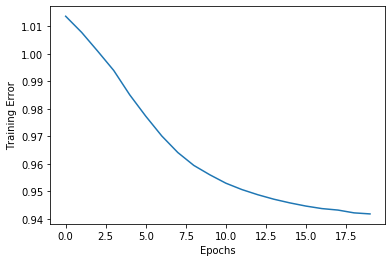

In [30]:
from keras.models import load_model

if os.path.exists('regression_model.h5'):
    model = load_model('regression_model.h5')
else:
    history = model.fit([train.user_id, train.movie_id], train.rating, epochs=20, verbose=1)
    model.save('regression_model.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [31]:
model.evaluate([test.user_id, test.movie_id], test.rating)

117696/117696 [==============================] - 1s 13us/step


1.019817852322468

In [32]:
pred = model.predict([test.user_id.head(10), test.movie_id.head(10)])

[print(pred[i], test.rating.iloc[i]) for i in range(0,10)]

[3.3439445] 2
[3.804296] 4
[4.376895] 4
[3.8162637] 1
[3.729398] 4
[5.1371527] 4
[3.7215402] 5
[4.634318] 4
[4.6818557] 4
[5.0189753] 5


[None, None, None, None, None, None, None, None, None, None]

In [33]:
prediction = model.predict([samples.user_id, samples.movie_id])

In [34]:
for i in range(prediction.shape[0]):
    prediction[i] = int(prediction[i])
    if (prediction[i] < 1):
        prediction[i] = 1
    elif (prediction[i] > 5):
        prediction[i] = 5

In [35]:
submission = load_data(DATA_TEST_PATH)
submission['rating'] = prediction

In [36]:
from helpers import create_csv

DATA_SUBMISSION = "data/submission_dotprod1.csv"
create_csv(DATA_SUBMISSION, submission)

Dot Product with RMSE using librairies : pandas and keras - AICrowd : 1.166

The score stays the same when we increase 'epoch'.